# Analysing multigrid approach with fast_tsne implementation

In [25]:
from time import time
from datetime import datetime
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# sys.path.append(os.path.abspath("."))  # add src/ to path
# from utils.load_dataset import get_mnist, get_fmnist, get_tasic2018

sys.path.insert(0, r"C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB")
from src.utils.load_dataset import get_mnist, get_fmnist, load_flow18, load_wong, load_celegans, get_tasic2018

# the path should point to the FIt-SNE directory
sys.path.append('../FIt-SNE')
from fast_tsne import fast_tsne

In [26]:
def get_dataset(dataset_id):
    """
    Given the name of a data set, load the corresponding data set.
    Parameters
    ----------
    dataset_id : String
        Number of points to be embedded in total
    Returns
    -------
    dataset_id, X, labels : String, CSR_matrix, list[]
        Name of the data set, the data, data labels
    """

    if dataset_id == "mnist":
        print("Loading MNIST data")
        mnist_data_dir = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/mnist")
        return ["mnist", ] + list(get_mnist(mnist_data_dir))
    elif dataset_id == "wong":
        wong_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/wong")
        result = load_wong(data_home= wong_path, labels_name="broad", return_colors=False)
        X, labels = result
        return ["wong", X, labels]
    elif dataset_id == "flow18":
        flow18_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main/mg-emb-exps-main/data/flow18/flow18_annotated.fcs")
        X, labels = load_flow18(flow18_path)
        return ["flow18", X, labels]
    elif dataset_id == "c_elegans":
        celegans_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/c_elegans")
        X, labels = load_celegans(data_home=celegans_path, return_X_y=True)
        return ["c_elegans", X, labels] 
    else:
        print("[perp-vs-num_samples] Dataset `{}` not supported.".format(dataset_id))

#### plotting embeddings logic

In [27]:
# Use plot_grid to visualize all embeddings
def plot_grid(embeddings_to_be_plotted, row_var="perplexity", col_var="num_samples", figsize=None, axis=False, suptitle=None, supxlabel=None, supylabel=None, in_title=None):
    
    rows = sorted(set([e[row_var] for e in embeddings_to_be_plotted]))
    cols = sorted(set([e[col_var] for e in embeddings_to_be_plotted]))

    nrows = len(rows)
    ncols = len(cols)

    if in_title is None:
        in_title = [row_var, col_var]
    if figsize is None:
        figsize = (ncols * 7, nrows * 7)  # was (ncols*3, nrows*4)


    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout="tight")
    if type(axes) != np.ndarray:
        axes = np.array(axes)
    axes = axes.reshape(nrows, ncols)

    for ri, rl in enumerate(rows):
        for ci, cl in enumerate(cols):
            
            emb_list = [emb for emb in embeddings_to_be_plotted if emb[row_var] == rl and emb[col_var] == cl]
            if not emb_list:
                print(f"Warning: No embedding found for {row_var}={rl}, {col_var}={cl}")
                continue  # Skip plotting for this cell
            emb_data = emb_list[0]
            
            axes[ri, ci].scatter(
                emb_data["embedding"][:, 0],
                emb_data["embedding"][:, 1],
                s=2, # Smaller size
                c=emb_data["labels"],
                cmap="tab10",
                alpha=0.4  # Transparency: 0 (invisible) to 1 (opaque)
            )

            if not axis:
                axes[ri, ci].set_axis_off()

            
            title_lines = []
            for display_name, key in in_title.items():
                val = emb_data.get(key, "N/A")
                if isinstance(val, float):
                    title_lines.append(f"{display_name}: {val:.2f}")
                else:
                    title_lines.append(f"{display_name}: {val}")
            axes[ri, ci].set_title("\n".join(title_lines), fontsize=14)
            


    if suptitle is not None:
        figure.suptitle(suptitle)

    if supxlabel is not None:
        figure.supxlabel(supxlabel)

    if supylabel is not None:
        figure.supylabel(supylabel)

    return figure, axes

In [ ]:
# Use plot_grid to visualize all embeddings
def plot_grid_with_metrics(embeddings_to_be_plotted, row_var="perplexity", col_var="num_samples", figsize=None, axis=False, suptitle=None, supxlabel=None, supylabel=None, in_title=None):
    
    rows = sorted(set([e[row_var] for e in embeddings_to_be_plotted]))
    cols = sorted(set([e[col_var] for e in embeddings_to_be_plotted]))

    nrows = len(rows)
    ncols = len(cols)

    if in_title is None:
        in_title = [row_var, col_var]
    if figsize is None:
        figsize = (ncols * 7, nrows * 7) # was 7


    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout="tight")
    if type(axes) != np.ndarray:
        axes = np.array(axes)
    axes = axes.reshape(nrows, ncols)

    for ri, rl in enumerate(rows):
        for ci, cl in enumerate(cols):
            
            emb_list = [emb for emb in embeddings_to_be_plotted if emb[row_var] == rl and emb[col_var] == cl]
            if not emb_list:
                print(f"Warning: No embedding found for {row_var}={rl}, {col_var}={cl}")
                continue  # Skip plotting for this cell
            emb_data = emb_list[0]
            
            axes[ri, ci].scatter(
                emb_data["embedding"][:, 0],
                emb_data["embedding"][:, 1],
                s=2, # Smaller size
                c=emb_data["labels"],
                cmap="tab10",
                alpha=0.4 # Transparency: 0 (invisible) to 1 (opaque)
            )

            if not axis:
                axes[ri, ci].set_axis_off()


            # Title (just perplexity/sample size info)
            # title_lines = [f"{l}: {emb_data[l]:.4f}" if isinstance(emb_data[l], float) else f"{l}: {emb_data[l]}" for l in in_title]
            # axes[ri, ci].set_title("\n".join(title_lines), fontsize=24)

            title_lines = []
            for display_name, key in in_title.items():
                val = emb_data.get(key, "N/A")
                if isinstance(val, float):
                    title_lines.append(f"{display_name}: {val:.2f}")
                else:
                    title_lines.append(f"{display_name}: {val}")
            axes[ri, ci].set_title("\n".join(title_lines), fontsize=16)

            # Metrics in bottom-right corner of axes
            ax = axes[ri, ci]
            ax.text(0.75, 0.02, 'KNN:\nKNC:\nCPD:', transform=ax.transAxes, fontsize=16)
            ax.text(
                0.87, 0.02,
                '{:.2f}\n{:.2f}\n{:.2f}'.format(
                    emb_data.get('mnn', 0),
                    emb_data.get('knc', 0),
                    emb_data.get('cpd', 0)
                ),
                transform=ax.transAxes, fontsize=16
            )


    if suptitle is not None:
        figure.suptitle(suptitle)

    if supxlabel is not None:
        figure.supxlabel(supxlabel)

    if supylabel is not None:
        figure.supylabel(supylabel)

    return figure, axes

In [29]:
def save_fig(figure, dataset_id, fname, overwrite=False):

    # Get current date formatted as dd-mm-yy
    folder_timestamp = datetime.now().strftime("%d-%m-%y")

    if dataset_id is not None:
        figures_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" /dataset_id / folder_timestamp
        figures_dir.mkdir(parents=True, exist_ok=True)
    else:
        # Default figures directory
        figures_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "default"
        figures_dir.mkdir(parents=True, exist_ok=True)

    full_path = figures_dir / fname

    if full_path.exists() and not overwrite:
        print(f"File already exists. Remove or rename {full_path} before continuing.")
    else:
        figure.savefig(full_path)
        print(f"Figure saved to {full_path}")

#### mg_tsne with fast_tsne implementation

In [30]:
def mg_tsne(
    initial_embedding,
    sample_rate,
    sample_perplexity,
    full_perplexity,
    rnd_state=42
):
    
    start = time()

    # Sample the data
    np.random.seed(rnd_state)
    print("Sampling the data...")
    sample_ids = np.random.choice(
        np.arange(0, initial_embedding.shape[0]),
        size=int(initial_embedding.shape[0] * sample_rate),
        replace=False
    )
    sample_ids.sort()
    sampled_initial_embedding = initial_embedding[sample_ids, :]
    sampled_pca_data = initial_embedding[sample_ids, :]
    print("DONE.")
    

    # Run fast_tsne on sampled data
    # returns a 2D embedding
    print("Applying fast_tsne on the sampled data...")
    initial_tSNE_embedding = fast_tsne(
        sampled_initial_embedding,
        perplexity=sample_perplexity,
        initialization="pca",
        seed=rnd_state,
        
        early_exag_coeff=12,
        stop_early_exag_iter=250,
        max_iter=1000,
        
        learning_rate="auto", # internally becomes max(200, n/early_exag_coeff), uses m sampled points so m/12
        momentum=0.5,
        final_momentum=0.8
    )
    print("DONE.")


    # Prolongation: Initialize full embedding with NaN and assign sample embeddings
    print("Prolongating the sample embedding to the full dataset...")
    prolongated_embedding = np.empty((initial_embedding.shape[0], 2))
    prolongated_embedding[:] = np.NAN
    prolongated_embedding[sample_ids, :] = initial_tSNE_embedding
    # Use nearest neighbor from sampled points for each unsampled point
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(sampled_pca_data)
    dists, nearest = nn.kneighbors(initial_embedding)
    for i in range(initial_embedding.shape[0]):
        if np.isnan(prolongated_embedding[i, 0]):
            prolongated_embedding[i, :] = initial_tSNE_embedding[nearest[i, 0]]
    print("DONE.")


    # Run fast_tsne on full data using prolongated embedding as initialization
    print("Applying fast_tsne on the full dataset with no exaggeration...")
    full_embedding = fast_tsne(
        initial_embedding,
        perplexity=full_perplexity,
        initialization=prolongated_embedding,
        seed=rnd_state,

        early_exag_coeff=1.0, # no early exaggeration
        stop_early_exag_iter=0,
        max_iter=750,
        
        learning_rate="auto", # internally becomes max(200, n/early_exag_coeff)
        momentum=0.5,
        final_momentum=0.5
    )
    print("DONE.")


    print(f"-> Total time for running mg_tsne took {(time() - start) / 60:.2f} minutes.")
    return full_embedding

#### calculating embedding's quality for an embedding

In [31]:
def embedding_quality(X, Z, classes, knn=10, knn_classes=4, subsetsize=1000):
    # Local neighborhood preservation (kNN)
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / (X.shape[0] * knn)

    # Global neighborhood consistency (KNC)
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size

    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
 
    # compute the centroid of each class in both the high-dimensional space (mu1) and the embedding (mu2).
    for c in range(C):
        mu1[c, :] = np.mean(X[cl_inv == c, :], axis=0)
        mu2[c, :] = np.mean(Z[cl_inv == c, :], axis=0)

    knn_classes = min(knn_classes, max(1, C - 1))  # Prevent requesting more neighbors than class centers
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / (C * knn_classes)

    # Spearman correlation of pairwise distances (CPD)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset, :])
    d2 = pdist(Z[subset, :])
    rho = spearmanr(d1, d2).correlation

    return mnn, mnn_global, rho

#### Prepare data

In [32]:
# data to be used for the experiment
#cdataset_id = "c_elegans"
# dataset_id = "mnist"
dataset_id = "wong"
# dataset_id = "flow18"

dataset_name, data_to_be_embedded, labels = get_dataset(dataset_id)

# size of the dataset
num_points = data_to_be_embedded.shape[0]
num_features = data_to_be_embedded.shape[1]
print(f"Dataset `{dataset_name}` has {num_points} points with {num_features} features each.")
print("Number of unique classes:", len(np.unique(labels)))


# for c_elegans, Convert sparse matrix to dense if necessary
if dataset_id == "c_elegans":
    if hasattr(data_to_be_embedded, "toarray"):
        data_to_be_embedded = data_to_be_embedded.toarray()


# Reduce dataset size for flow18
if dataset_id == "flow18":
    rng = np.random.default_rng(seed=42)
    subset_indices = rng.choice(num_points, size=num_points // 2, replace=False)
    data_to_be_embedded = data_to_be_embedded[subset_indices]
    labels = labels[subset_indices]
    print(f"Reduced dataset size to {data_to_be_embedded.shape[0]} points for flow18.")


print("Applying PCA...")
# Centering the data.
data_to_be_embedded = data_to_be_embedded - data_to_be_embedded.mean(axis=0)
# Decomposing it via SVD.
U, s, V = np.linalg.svd(data_to_be_embedded, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
# Projecting onto the top components via U * s.
data_to_be_embedded = np.dot(U, np.diag(s))
initial_embedding = data_to_be_embedded[:, np.argsort(s)[::-1]][:, :50]
print("DONE.")


# Define experiment settings
# define the sample rate
sample_rate = 0.1

# mnist
# limit = 1250
# sample_perplexities = [10, 30, 300, 500, 1000, 1250]
# full_perplexities = [10, 30, 300, 500, 1000, 1250]
# test perplexities
# sample_perplexities = [30]
# full_perplexities = [700]

# c_elegans
# limit = 750
# sample_perplexities = [30, 100, 300, 500, 750]
# full_perplexities = [30, 100, 300, 500, 750]
# test perplexities
# sample_perplexities = [30, 100, 300, 500, 750]
# full_perplexities = [300]


# wong
# limit = 500
# sample_perplexities = [10, 30, 100, 300, 500]
# full_perplexities = [10, 30, 100, 300, 500]
# test perplexities
sample_perplexities = [30]
full_perplexities = [372]


# flow18
# limit = 500  
# sample_perplexities = [10, 30, 100, 300, 500]
# full_perplexities = [10, 30, 100, 300, 500]
# test perplexities
# sample_perplexities = [10]
# full_perplexities = [500]


C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB\data\wong
Dataset `wong` has 327457 points with 39 features each.
Number of unique classes: 6
Applying PCA...
DONE.


## Run t-SNE row wise

- calculates embedding quality of each embedding and adds it to the result's object for this embedding. All the qualities can be plotted row wise later
- calculates CPD between embeddings across the row where the reference embedding is the first one.
    - the plot is created after each row is completed

In [33]:
# Container to collect results
results = []
# cache for comparing embeddings across full_perps
embedding_reference_by_sample_perp = {}
cpd_between_embeddings_records = []

# Run grid search over (sample_perplexity, full_perplexity)
for sample_perp in sample_perplexities:
    for full_perp in full_perplexities:

        print(f"Running for sample_perp={sample_perp}, full_perp={full_perp}...")

        # Step 2: Run mg_tsne
        print("Running mg_tsne...")
        final_embedding = mg_tsne(
            initial_embedding=initial_embedding,
            sample_rate=sample_rate,
            sample_perplexity=sample_perp,
            full_perplexity=full_perp,
            rnd_state=42
        )
        print("finished running mg_tsne.")

        # Compute embedding quality
        print("Computing embedding quality metrics...")
        mnn, mnn_global, rho = embedding_quality(
            X=initial_embedding,
            Z=final_embedding,
            classes=labels,
            knn=10,
            knn_classes=4,
            subsetsize=1000
        )
        print(f"Quality - mnn: {mnn:.3f}, knc: {mnn_global:.3f}, cpd: {rho:.3f}")
        

        print("calculating CPD between the first embedding and this embedding...")
        # Subsample 1000 points to compute CPD
        # Are we sampling the same points every time?
        subset_indices = np.random.choice(final_embedding.shape[0], size=1000, replace=False)
        emb_subset = final_embedding[subset_indices, :]
        cpd_value = None

        if sample_perp not in embedding_reference_by_sample_perp:
            # Save this embedding as reference (for lowest full_perp or first time)
            embedding_reference_by_sample_perp[sample_perp] = emb_subset
        else:
            # Compare with reference embedding
            ref_embedding = embedding_reference_by_sample_perp[sample_perp]
            d1 = pdist(ref_embedding)
            d2 = pdist(emb_subset)
            cpd_value = spearmanr(d1, d2).correlation

            cpd_between_embeddings_records.append({
                "sample_perplexity": sample_perp,
                "full_perplexity": full_perp,
                "cpd_value": cpd_value
            })


        results.append({
            "sample_perplexity": sample_perp,
            "full_perplexity": full_perp,
            "embedding": final_embedding,
            "labels": labels,
            "mnn": mnn,
            "knc": mnn_global,
            "cpd": rho
        })

        print("\n\n")

Running for sample_perp=30, full_perp=372...
Running mg_tsne...
Sampling the data...
DONE.
Applying fast_tsne on the sampled data...
DONE.
Prolongating the sample embedding to the full dataset...
DONE.
Applying fast_tsne on the full dataset with no exaggeration...
DONE.
-> Total time for running mg_tsne took 24.29 minutes.
finished running mg_tsne.
Computing embedding quality metrics...
Quality - mnn: 0.074, knc: 0.750, cpd: 0.571
calculating CPD between the first embedding and this embedding...





#### Plot the embeddings

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\multi-grid\fast_tsne\wong\22-06-25\wong_30_372_~_04-57-26.png





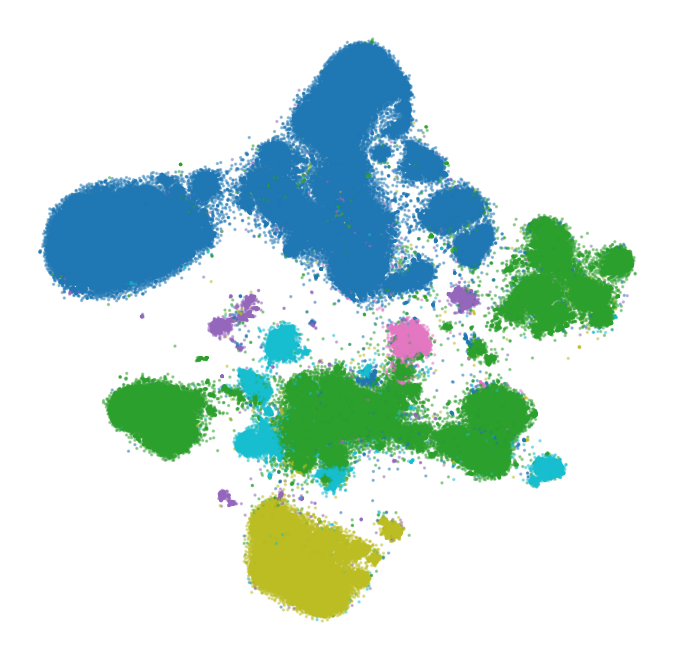

In [35]:
# plot the embedding
figure, axes = plot_grid(
    embeddings_to_be_plotted=results,
    row_var="sample_perplexity",
    col_var="full_perplexity",
    figsize=None,
    suptitle="",
    supxlabel="",
    supylabel="",
    # in_title = {
    #     "Sample Perplexity": "sample_perplexity",
    #     "Full Perplexity": "full_perplexity"
    # }
    in_title = {}
)

# save the figure
file_name_timestamp = datetime.now().strftime("%H-%M-%S")
filename = f"{dataset_id}_{sample_perp}_{full_perp}_~_{file_name_timestamp}.png"
save_fig(figure, dataset_id, filename, overwrite=True)
print("\n\n")

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\multi-grid\fast_tsne\wong\22-06-25\wong_30_372_~_04-57-01_with_metrics.png





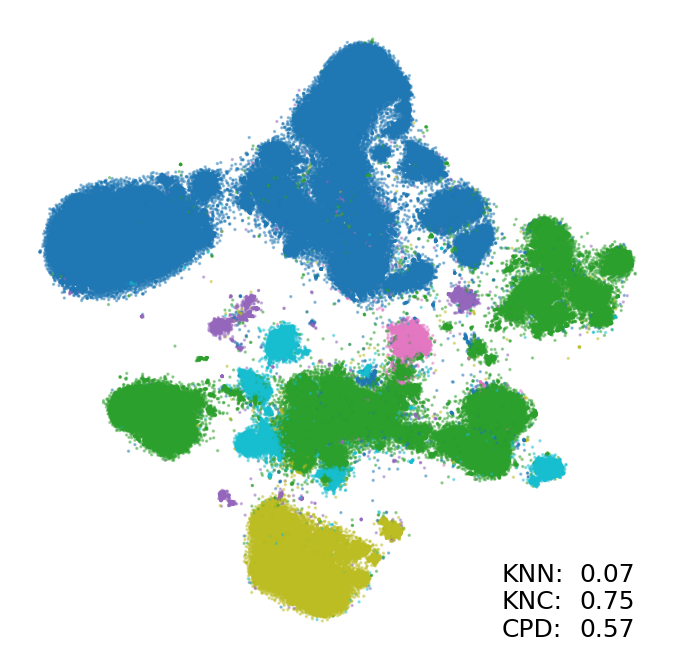

In [34]:
# plot the embedding with metrics
figure_metrics, axes = plot_grid_with_metrics(
    embeddings_to_be_plotted=results,
    row_var="sample_perplexity",
    col_var="full_perplexity",
    figsize=None,
    suptitle="",
    supxlabel="",
    supylabel="",
    # in_title = {
    #     "Sample Perplexity": "sample_perplexity",
    #     "Full Perplexity": "full_perplexity"
    # }
    in_title = {}
)

# save the figure
file_name_timestamp = datetime.now().strftime("%H-%M-%S")
filename = f"{dataset_id}_{sample_perp}_{full_perp}_~_{file_name_timestamp}_with_metrics.png"
save_fig(figure_metrics, dataset_id, filename, overwrite=True)
print("\n\n")

#### Generate csv file containing cpd values between embeddings across the rows and save the file

In [ ]:
# Create and save the raw (long-form) CSV
cpd_df = pd.DataFrame(cpd_between_embeddings_records)

# Construct save path as per `save_fig`
folder_timestamp = datetime.now().strftime("%d-%m-%y")
if dataset_id is not None:
    cpd_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / dataset_id / folder_timestamp
else:
    cpd_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "default" / folder_timestamp
cpd_dir.mkdir(parents=True, exist_ok=True)

# Filename and save
cpd_filename = f"{dataset_id}_cpd_longform_{datetime.now().strftime('%H-%M-%S')}.csv"
cpd_path = cpd_dir / cpd_filename
cpd_df.to_csv(cpd_path, index=False)
print(f"Saved CPD (long-form) to {cpd_path}")

#### Plot embedding quality for each individual embedding across the rows

In [ ]:
import pandas as pd

# Convert results into a DataFrame for easy grouping and plotting
df_results = pd.DataFrame(results)

# For each unique sample_perplexity, plot metrics vs full_perplexity
for sample_perp in df_results['sample_perplexity'].unique():
    subset = df_results[df_results['sample_perplexity'] == sample_perp].sort_values(by="full_perplexity")

    fig = plt.figure(figsize=(10, 6))
    plt.plot(subset['full_perplexity'], subset['mnn'], marker='o', label='kNN')
    plt.plot(subset['full_perplexity'], subset['knc'], marker='s', label='KNC')
    plt.plot(subset['full_perplexity'], subset['cpd'], marker='^', label='CPD')

    plt.title(f"Sample Perplexity: {sample_perp}", fontsize=18)
    # plt.title("")
    plt.xlabel("Full Perplexity", fontsize=18)
    plt.ylabel("Metric Value", fontsize=18)

    plt.xticks(fontsize=18)  # <-- tick label font size for x-axis
    plt.yticks(fontsize=18)  # <-- tick label font size for y-axis
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

    metric_plot_filename = f"quality_metrics_sampleperp_{sample_perp}.png"
    save_fig(fig, dataset_id, metric_plot_filename)
    print(f"Saved metric plot as {metric_plot_filename}")

#### Plot embedding quality for each individual embedding across the columns

In [ ]:
# Group by full_perplexity → varying sample_perplexity
for full_perp in df_results['full_perplexity'].unique():
    subset = df_results[df_results['full_perplexity'] == full_perp].sort_values(by="sample_perplexity")

    fig = plt.figure(figsize=(10, 6))
    plt.plot(subset['sample_perplexity'], subset['mnn'], marker='o', label='kNN')
    plt.plot(subset['sample_perplexity'], subset['knc'], marker='s', label='KNC')
    plt.plot(subset['sample_perplexity'], subset['cpd'], marker='^', label='CPD')

    plt.title(f"Full Perplexity: {full_perp}", fontsize=18)
    plt.xlabel("Sample Perplexity", fontsize=18)
    plt.ylabel("Metric Value", fontsize=18)

    plt.xticks(fontsize=18)  # <-- tick label font size for x-axis
    plt.yticks(fontsize=18)  # <-- tick label font size for y-axis

    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

    metric_plot_filename = f"quality_metrics_fullperp_{full_perp}.png"
    save_fig(fig, dataset_id, metric_plot_filename)
    print(f"Saved metric plot as {metric_plot_filename}")

## Column Wise t-SNE

#### Prepare Data

In [ ]:
# data to be used for the experiment
#cdataset_id = "c_elegans"
dataset_id = "mnist"
# dataset_id = "wong"
# dataset_id = "flow18"

dataset_name, data_to_be_embedded, labels = get_dataset(dataset_id)

# size of the dataset
num_points = data_to_be_embedded.shape[0]
num_features = data_to_be_embedded.shape[1]
print(f"Dataset `{dataset_name}` has {num_points} points with {num_features} features each.")
print("Number of unique classes:", len(np.unique(labels)))


# for c_elegans, Convert sparse matrix to dense if necessary
if dataset_id == "c_elegans":
    if hasattr(data_to_be_embedded, "toarray"):
        data_to_be_embedded = data_to_be_embedded.toarray()


# Reduce dataset size for flow18
if dataset_id == "flow18":
    rng = np.random.default_rng(seed=42)
    subset_indices = rng.choice(num_points, size=num_points // 2, replace=False)
    data_to_be_embedded = data_to_be_embedded[subset_indices]
    labels = labels[subset_indices]
    print(f"Reduced dataset size to {data_to_be_embedded.shape[0]} points for flow18.")


print("Applying PCA...")
# Centering the data.
data_to_be_embedded = data_to_be_embedded - data_to_be_embedded.mean(axis=0)
# Decomposing it via SVD.
U, s, V = np.linalg.svd(data_to_be_embedded, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
# Projecting onto the top components via U * s.
data_to_be_embedded = np.dot(U, np.diag(s))
initial_embedding = data_to_be_embedded[:, np.argsort(s)[::-1]][:, :50]
print("DONE.")


# Define experiment settings
# define the sample rate
sample_rate = 0.1

# mnist
# limit = 1250
# sample_perplexities = [10, 30, 300, 500, 1000, 1250]
# full_perplexities = [10, 30, 300, 500, 1000, 1250]
# test perplexities
sample_perplexities = [30]
full_perplexities = [700]

# c_elegans
# limit = 750
# sample_perplexities = [30, 100, 300, 500, 750]
# full_perplexities = [30, 100, 300, 500, 750]
# test perplexities
# sample_perplexities = [30, 100, 300, 500, 750]
# full_perplexities = [300]


# wong
# limit = 500
# sample_perplexities = [10, 30, 100, 300, 500]
# full_perplexities = [10, 30, 100, 300, 500]
# test perplexities
# sample_perplexities = [30]
# full_perplexities = [30]


# flow18
# limit = 500  
# sample_perplexities = [10, 30, 100, 300, 500]
# full_perplexities = [10, 30, 100, 300, 500]
# test perplexities
# sample_perplexities = [10]
# full_perplexities = [500]

In [ ]:
columnwise_results = []
embedding_reference_by_full_perp = {}
cpd_between_columns_records = []

for full_perp in full_perplexities:
    for sample_perp in sample_perplexities:

        print(f"Running for full_perp={full_perp}, sample_perp={sample_perp}...")

        # Run mg_tsne
        final_embedding = mg_tsne(
            initial_embedding=initial_embedding,
            sample_rate=sample_rate,
            sample_perplexity=sample_perp,
            full_perplexity=full_perp,
            rnd_state=42
        )

        # Evaluate quality metrics
        mnn, mnn_global, rho = embedding_quality(
            X=initial_embedding,
            Z=final_embedding,
            classes=labels,
            knn=10,
            knn_classes=4,
            subsetsize=1000
        )

        # Subsample for CPD
        subset_indices = np.random.choice(final_embedding.shape[0], size=1000, replace=False)
        emb_subset = final_embedding[subset_indices, :]
        cpd_value = None

        if full_perp not in embedding_reference_by_full_perp:
            # First sample_perp becomes reference in this column
            embedding_reference_by_full_perp[full_perp] = emb_subset
        else:
            # Compare current embedding with reference
            ref_embedding = embedding_reference_by_full_perp[full_perp]
            d1 = pdist(ref_embedding)
            d2 = pdist(emb_subset)
            cpd_value = spearmanr(d1, d2).correlation

            cpd_between_columns_records.append({
                "full_perplexity": full_perp,
                "sample_perplexity": sample_perp,
                "cpd_value": cpd_value
            })

        columnwise_results.append({
            "sample_perplexity": sample_perp,
            "full_perplexity": full_perp,
            "embedding": final_embedding,
            "labels": labels,
            "mnn": mnn,
            "knc": mnn_global,
            "cpd": rho
        })

        print("\n\n")


#### Generate csv file containing cpd values between embeddings across the rows and save the file

In [ ]:
# Create DataFrame
cpd_col_df = pd.DataFrame(cpd_between_columns_records)

# Save
folder_timestamp = datetime.now().strftime("%d-%m-%y")
if dataset_id is not None:
    cpd_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / dataset_id / folder_timestamp
else:
    cpd_dir = Path.cwd() / "figures" / "multi-grid" / "fast_tsne" / "default" / folder_timestamp
cpd_dir.mkdir(parents=True, exist_ok=True)

# Save CSV
cpd_filename = f"{dataset_id}_cpd_colwise_{datetime.now().strftime('%H-%M-%S')}.csv"
cpd_path = cpd_dir / cpd_filename
cpd_col_df.to_csv(cpd_path, index=False)
print(f"Saved CPD (column-wise) to {cpd_path}")
